# 11 空間構造のある階層ベイズモデル

In [1]:
using CSV
using DataFrames
using Plots

## 11.1 例題 : 一次元空間上の個体数分布 

In [2]:
df = CSV.read("data/section11.csv")
disallowmissing!(df)

,y,m
,Int64,Float64
1,0,2.15498
2,3,3.25417
3,2,4.62867
4,5,6.23412
5,6,7.99073
6,16,9.79447
7,8,11.5334
8,14,13.1043
9,11,14.4263


### 例題の一次元空間上の架空データ
横軸は調査区間の位置, 縦軸は観測された個体数, 破線はデータをポアソン乱数で生成するときに使った平均値

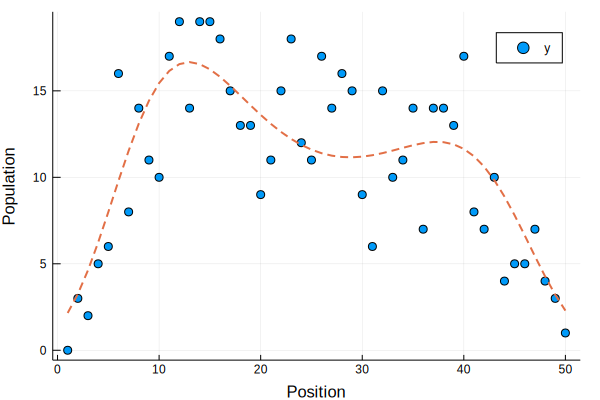

In [3]:
scatter(1:50, df.y, xlabel = "Position", ylabel = "Population", label = "y")
plot!(1:50, df.m, linewidth = 2, linestyle = :dash, label = "")

## 11.3 空間統計モデルをデータに当てはめる
### intrinsic Gaussian CARモデルの実装
CARモデルのPyMC3実装を参考にして, intrinsic Gaussian CARモデルを実装する    
https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html

まずは同様にScotlandのlip cancer risk dataを準備する. 元データは  
Kemp I. (1989) Scottish Cancer Incidence Atlas 1985. In: Boyle P., Muir C.S., Grundmann E. (eds) Cancer Mapping. Recent Results in Cancer Research, vol 114. Springer, Berlin, Heidelberg

In [16]:
observed = [9, 39, 11, 9, 15, 8, 26, 7, 6, 20, 13, 5, 3, 8, 17, 9, 2, 7, 9, 7, 16,
            31, 11, 7, 19, 15, 7, 10, 16, 11, 5, 3, 7, 8, 11, 9, 11, 8, 6, 4, 10,
            8, 2, 6, 19, 3, 2, 3, 28, 6, 1, 1, 1, 1, 0, 0]

expected = [1.4, 8.7, 3.0, 2.5, 4.3, 2.4, 8.1, 2.3, 2.0, 6.6, 4.4, 1.8, 1.1, 3.3,
              7.8, 4.6, 1.1, 4.2, 5.5, 4.4, 10.5, 22.7, 8.8, 5.6, 15.5, 12.5, 6.0,
              9.0, 14.4, 10.2, 4.8, 2.9, 7.0, 8.5, 12.3, 10.1, 12.7, 9.4, 7.2, 5.3,
              18.8, 15.8, 4.3, 14.6, 50.7, 8.2, 5.6, 9.3, 88.7, 19.6, 3.4, 3.6, 5.7,
              7.0, 4.2, 1.8]

aff = [16, 16, 10, 24, 10, 24, 10, 7, 7, 16, 7, 16, 10, 24, 7, 16, 10, 7,
        7, 10, 7, 16, 10, 7, 1, 1, 7, 7, 10, 10, 7, 24, 10, 7, 7, 0, 10, 1,
        16, 0, 1, 16, 16, 0, 1, 7, 1, 1, 0, 1, 1, 0, 1, 1, 16, 10] ./ 10;

In [15]:
adj = [[5, 9, 11,19],
        [7, 10],
        [6, 12],
        [18,20,28],
        [1, 11,12,13,19],
        [3, 8],
        [2, 10,13,16,17],
        [6],
        [1, 11,17,19,23,29],
        [2, 7, 16,22],
        [1, 5, 9, 12],
        [3, 5, 11],
        [5, 7, 17,19],
        [31,32,35],
        [25,29,50],
        [7, 10,17,21,22,29],
        [7, 9, 13,16,19,29],
        [4,20, 28,33,55,56],
        [1, 5, 9, 13,17],
        [4, 18,55],
        [16,29,50],
        [10,16],
        [9, 29,34,36,37,39],
        [27,30,31,44,47,48,55,56],
        [15,26,29],
        [25,29,42,43],
        [24,31,32,55],
        [4, 18,33,45],
        [9, 15,16,17,21,23,25,26,34,43,50],
        [24,38,42,44,45,56],
        [14,24,27,32,35,46,47],
        [14,27,31,35],
        [18,28,45,56],
        [23,29,39,40,42,43,51,52,54],
        [14,31,32,37,46],
        [23,37,39,41],
        [23,35,36,41,46],
        [30,42,44,49,51,54],
        [23,34,36,40,41],
        [34,39,41,49,52],
        [36,37,39,40,46,49,53],
        [26,30,34,38,43,51],
        [26,29,34,42],
        [24,30,38,48,49],
        [28,30,33,56],
        [31,35,37,41,47,53],
        [24,31,46,48,49,53],
        [24,44,47,49],
        [38,40,41,44,47,48,52,53,54],
        [15,21,29],
        [34,38,42,54],
        [34,40,49,54],
        [41,46,47,49],
        [34,38,49,51,52],
        [18,20,24,27,56],
        [18,24,30,33,45,55]];

In [28]:
# weights = fill!.(similar.(adj), 1)

56-element Array{Array{Int64,1},1}:
 [1, 1, 1, 1]               
 [1, 1]                     
 [1, 1]                     
 [1, 1, 1]                  
 [1, 1, 1, 1, 1]            
 [1, 1]                     
 [1, 1, 1, 1, 1]            
 [1]                        
 [1, 1, 1, 1, 1, 1]         
 [1, 1, 1, 1]               
 [1, 1, 1, 1]               
 [1, 1, 1]                  
 [1, 1, 1, 1]               
 ⋮                          
 [1, 1, 1, 1]               
 [1, 1, 1, 1, 1, 1]         
 [1, 1, 1, 1, 1, 1]         
 [1, 1, 1, 1]               
 [1, 1, 1, 1, 1, 1, 1, 1, 1]
 [1, 1, 1]                  
 [1, 1, 1, 1]               
 [1, 1, 1, 1]               
 [1, 1, 1, 1]               
 [1, 1, 1, 1, 1]            
 [1, 1, 1, 1, 1]            
 [1, 1, 1, 1, 1, 1]         

In [31]:
w_plus = length.(adj)

56-element Array{Int64,1}:
 4
 2
 2
 3
 5
 2
 5
 1
 6
 4
 4
 3
 4
 ⋮
 4
 6
 6
 4
 9
 3
 4
 4
 4
 5
 5
 6

### 確率分布を作る

Julia言語における確率分布の作り方  
https://gist.github.com/genkuroki/2bcf945f01af2372bab86b1e1214d6e9

User-Defined Univariate Distributions  
https://mambajl.readthedocs.io/en/latest/mcmc/distributions.html#user-defined-univariate-distributions